# Classificação do gênero de filmes baseado em seu resumo

Rafael Gurgel

###### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Linkedin](https://linkedin.com/in/rafaelgurgel)

###### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Github](https://github.com/rurgel)


###### Julho 2022

### Configuração do ambiente

#### Importação das bibliotecas necessárias

In [1]:
import os                                                   # Controle das variáveis do sistema
import pandas as pd                                         # Manipulação de dataframes
from sklearn.model_selection import train_test_split        # Divide a base em conjuntos de treino e teste
from tensorflow.keras.preprocessing.text import Tokenizer   # Classe para tokenização
import pickle                                               # Salvar estruturas
from tensorflow.keras.callbacks import EarlyStopping        # Critério de parada de treinamento para evitar Overfitting
from tensorflow.keras.callbacks import ModelCheckpoint      # Salva o melhor modelo intermediário
import matplotlib.pyplot as plt                             # Biblioteca gráfica
from itertools import compress                              # Indexação booleana em lista (usado nos testes)
from tensorflow.nn import softmax                           # Normalizar probabilidades multiclasse
#---------------------------------------------------------  # Bibliotecas desenvolvidas
from src.get_target import target                           # Processa o target e separa por categorias
from src.nl_tools   import limpa_texto                      # Pré-processamento de Texto
from src.nl_tools   import gera_tokens                      # Tokenização e Padding 
from src.nl_models import nn_model                          # Modelo de rede neural para NLP 

#### Definição de constantes

In [2]:
NUMERO_PALAVRAS = 2048
OOV_TOKEN = "<UNK>"

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
%matplotlib inline

#### Carregamento dos dados

Os dados foram obtidos via internet a partir do arquivo ``scrap.py`` desenvolvido para baixar algumas páginas selecionadas no IMDB. Os dados já foram previamente pré-processados, identificados no idioma portugês ou então traduzido automaticamente e aplicada a lematização reduzindo palavras ao seu radical.

In [3]:
filmes = pd.read_csv('data/processed/imdb_pt_lemma.csv', sep=';')

### Análise do dados

In [4]:
display(filmes)

,Título,Descrição IMDB,Gênero,Nota,Descrição
0,O Quarto do Pânico,Uma trintona divorciada e a sua filha são apan...,"Policial,Drama,Suspense",6.8,um trintona divorciar e o seu filha ser apanha...
1,Pinte de Açafrão,A história de seis jovens índios que ajudam um...,"Comédia,Policial,Drama",8.1,o história de seis jovem índio que ajudar um i...
2,"Adeus, Minha Rainha",Um olhar sobre a relação platônica entre Maria...,"Drama,História,Romance",6.2,um olhar sobre o relação platônico entre Maria...
3,Paddleton,Uma amizade improvável entre dois vizinhos des...,"Comédia,Drama",7.1,um amizade improvável entre dois vizinho desaj...
4,ATL: O Som Do Gueto,Enquanto quatro amigos se preparam para a vida...,"Comédia,Policial,Drama",6.1,enquanto quatro amigo se preparar para o vida ...
...,...,...,...,...,...
9765,L'odore della notte,Um ex-policial vira criminoso em tempo integra...,"Policial,Drama,Suspense",6.9,um ex-policial ver criminoso em tempo integral...
9766,Os que Sabem Morrer,"Durante a Guerra da Coréia, um tenente desgast...","Ação,Drama,Guerra",7.2,"durante o Guerra de o Coréia, um tenente desga..."
9767,A Herança de Mr. Deeds,Um garoto da cidade e de natureza gentil começ...,"Comédia,Romance",5.8,um garoto de o cidade e de natureza gentil com...
9768,A Estrada Interior,Um jovem com síndrome de Tourette embarca em u...,"Aventura,Comédia,Drama",7.0,um jovem com síndrome de Tourette embarcar em ...


A função ``target`` foi desenvolvida com o objetivo de converter o texto relacionado ao gênero do filme para um conjunto de variáveis _dummies_. É importante observar que um filme pode possuir múltiplos gêneros.

Em seguida, analisa-se a proporção dos gêneros dos filmes observadas no conjunto de dados.

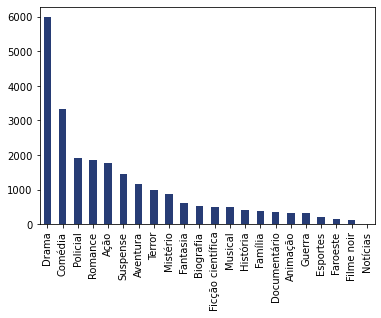

In [5]:
y, genero = target(filmes)
top_gen = pd.DataFrame(y, columns=genero).sum().astype(int).sort_values(ascending=False)
top_gen.plot(kind='bar', color='#273c75');

Há um considerável desbalanceamento de classes. Com o objetivo de simplificar e evitar alternativas de reamostragem que leva em conta a multiplicidade de gêneros, as classes mais raras não serão modeladas.

Nesse caso, serão considerados apenas os 10 gêneros mais frequentes.

In [6]:
genero = list(top_gen.index[:10])
y = target(filmes, genero=genero)[0]

In [7]:
print('Percentual dos gêneros dos filmes:',
      pd.DataFrame( y, columns=genero)
            .mean()
            .apply(lambda x: f'{100*x:.1f}%')
            .to_string(),
    sep='\n')

Percentual dos gêneros dos filmes:
Drama       61.4%
Comédia     34.0%
Policial    19.7%
Romance     18.9%
Ação        18.1%
Suspense    14.9%
Aventura    11.8%
Terror      10.2%
Mistério     8.8%
Fantasia     6.3%


É importante ressaltar que ainda há um desbalanceamento considerável, entretanto como esse é um projeto com fins didáticos, não serão analisadas questões de imputação de informações ou aplicação de pesos devido a complexidade dessa situação de múltiplas classes em sobreposiçãao.




#### Processa o texto e calcula as features

In [8]:
X = limpa_texto(filmes)
# Divide em conjuntos de treino e teste
train_x, test_x, \
train_y, test_y, \
train_t, test_t, \
train_d, test_d = train_test_split( X, y, 
                                    filmes['Título'], filmes['Descrição IMDB'],
                                    test_size=0.2, random_state=42)
# Tokenização
tokenizer = Tokenizer( oov_token=OOV_TOKEN, 
                       num_words=NUMERO_PALAVRAS,
                       lower=True)
# Ajusta para o conjunto de treino
tokenizer.fit_on_texts(train_x)
# Salva o modelo
with open('data/model/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)
# Gera a sequência
train_x = gera_tokens(tokenizer, train_x)
test_x  = gera_tokens(tokenizer, test_x, padding_len=train_x.shape[1])

### Treinamento do modelo

In [9]:
model = nn_model(train_x.shape[1], train_y.shape[1], NUMERO_PALAVRAS)

es = EarlyStopping( monitor='val_loss', 
                    mode='min', 
                    patience=5,
                    verbose=1)
mc = ModelCheckpoint( 'data/model/best_model.h5', 
                      monitor='val_loss', 
                      mode='min', 
                      save_best_only=True)

history = model.fit( train_x, train_y,
                     validation_data=(test_x, test_y),
                     batch_size=256, epochs=100, verbose=1,
                     callbacks=[es,mc]);

Epoch 1/100
31/31 [==============================] - 16s 183ms/step - loss: 1.6730 - AUC: 0.5053 - val_loss: 1.4085 - val_AUC: 0.4928
Epoch 2/100
31/31 [==============================] - 3s 84ms/step - loss: 1.2621 - AUC: 0.5136 - val_loss: 1.0455 - val_AUC: 0.4876
Epoch 3/100
31/31 [==============================] - 3s 84ms/step - loss: 0.9821 - AUC: 0.5116 - val_loss: 0.8526 - val_AUC: 0.5035
Epoch 4/100
31/31 [==============================] - 3s 83ms/step - loss: 0.8585 - AUC: 0.5192 - val_loss: 0.7969 - val_AUC: 0.5173
Epoch 5/100
31/31 [==============================] - 3s 82ms/step - loss: 0.8105 - AUC: 0.5302 - val_loss: 0.7798 - val_AUC: 0.5364
Epoch 6/100
31/31 [==============================] - 3s 82ms/step - loss: 0.7885 - AUC: 0.5544 - val_loss: 0.7688 - val_AUC: 0.5811
Epoch 7/100
31/31 [==============================] - 3s 83ms/step - loss: 0.7663 - AUC: 0.5997 - val_loss: 0.7624 - val_AUC: 0.5862
Epoch 8/100
31/31 [==============================] - 3s 82ms/step - loss: 

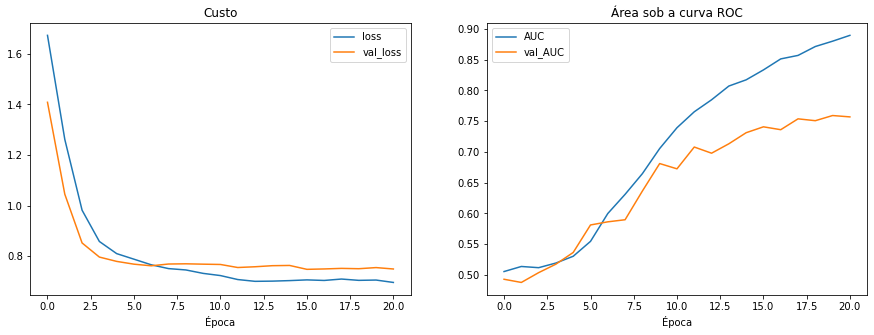

In [10]:
performance = pd.DataFrame(history.history)
fig,ax = plt.subplots(1,2, figsize=[15,5])
performance.filter(regex='loss').plot(ax=ax[0], title='Custo', xlabel='Época')
performance.filter(regex='AUC').plot(ax=ax[1], title='Área sob a curva ROC', xlabel='Época')
plt.show();

A performence do modelo treinado no conjunto de dados de validação baseado na área sob a curva ROC (média entre todos os gêneros) foi de aproximadamente 0.76 que é um bom resultado considerando o desbalanceamento entre as 10 classes.

#### Calibração do modelo

In [11]:
# Carrega o modelo inicialmente treinado por reproducibilidade
from keras.models import load_model
model = load_model('data/model/model.h5')

pred = model.predict(train_x)
from sklearn.isotonic import IsotonicRegression as IR
calib = list()
for i in range(train_y.shape[1]):
    calib.append(IR(out_of_bounds='clip'))
    calib[-1].fit(pred[:,i],train_y[:,i])

### Teste de performance

A seguir serão exibidos os resultados do classificador para alguns filmes do conjunto de **teste**.

In [12]:
def resultado_classificador(titulo):
    try:
        idx = list(test_t.str.lower()).index(titulo.lower())
    except Exception:
        print('Filme não encontrado no conjunto de teste.')
        return
    pred = model.predict(test_x[[idx]])
    for i,zp in enumerate(zip(pred,calib)):
        yp,ir = zp
        pred[i] =ir.transform(yp)
    print(test_d.iloc[idx], end= '\n\n\n')
    out = pd.Series(pred[0], index=genero).sort_values(ascending=False)
    out=out[out>0.05]
    out.values[:] = 100*(softmax(out).numpy())
    out = out.apply(lambda x: f'{x:.0f}%')
    print('Classificador:')
    print(out.to_string())
    print('\nTrue labels:', end=' ')
    print(*list(compress(genero, test_y[idx]==1)), sep=', ', end='.')

In [13]:
resultado_classificador('Homem de Ferro')

Depois de ficar preso em uma caverna afegã, o engenheiro multimilionário Tony Stark cria uma armadura única para combater o mal.


Classificador:
Comédia     34%
Ação        26%
Aventura    24%
Drama       16%

True labels: Ação, Aventura.

In [14]:
resultado_classificador('O conto de Zatoichi')

As aventuras de um massagista cego de jogo que também é um mestre espadachim.


Classificador:
Comédia     31%
Drama       26%
Ação        22%
Aventura    21%

True labels: Drama, Ação, Aventura.

In [15]:
resultado_classificador('Busca Explosiva')

Um grupo de ladrões de diamantes em fuga sequestra a esposa de um fuzileiro naval recentemente dispensado, que sai em perseguição deles, no meio da natureza selvagem da Carolina do Sul, para resgatá-la.


Classificador:
Ação        31%
Policial    19%
Drama       17%
Suspense    17%
Comédia     15%

True labels: Drama, Comédia, Ação.

In [16]:
resultado_classificador('Ostrov Sokrovishch')

Adaptação de desenhos animados do romance de aventura mais famoso de Robert Louis Stevenson.


Classificador:
Comédia     65%
Aventura    35%

True labels: Comédia, Aventura.

In [17]:
resultado_classificador('A trama')

Um repórter ambicioso se mete em problemas enquanto investiga o assassinato de um senador que leva a uma vasta conspiração envolvendo uma corporação multinacional por trás de cada evento no mundo.


Classificador:
Policial    27%
Drama       23%
Comédia     20%
Ação        18%
Suspense    13%

True labels: Drama, Suspense.

In [18]:
resultado_classificador('Sabrina')

Harrison Ford é Linus Larrabee, um magnata sem tempo para o amor. Quando um romance entre seu irmão playboy e Sabrina, filha do motorista da família, ameaça um dos negócios de Linus, ele revê sua agenda.


Classificador:
Comédia    41%
Drama      40%
Romance    19%

True labels: Drama, Comédia, Romance.

In [19]:
resultado_classificador('Paixão bandida')

Um ex-presidiário e seu irmão Crook Brook lutam pela mesma mulher.


Classificador:
Drama       47%
Comédia     34%
Policial    19%

True labels: Drama, Comédia, Policial.

In [20]:
resultado_classificador('Ano Um')

Após serem exilados de sua tribo, dois caçadores-coletores se encontram com personagens bíblicos e finalmente terminam na cidade de Sodoma.


Classificador:
Comédia     41%
Drama       21%
Aventura    20%
Fantasia    17%

True labels: Comédia.

In [21]:
resultado_classificador('O caçador de troll')

Um grupo de estudantes investiga uma série de misteriosas mortes de ursos, porém descobrem que há coisas muito mais perigosas acontecendo. Eles começam a seguir um caçador misterioso, descobrindo que ele é um caçador de tróis.


Classificador:
Terror      30%
Suspense    19%
Drama       17%
Mistério    17%
Fantasia    16%

True labels: Drama, Terror, Fantasia.

In [22]:
resultado_classificador('Pânico no Deserto')

Estranhos presos em um oásis de viagens misteriosos no deserto devem desvendar o mistério por trás de suas visões de morrer as pessoas enquanto são atacadas por uma criatura em decomposição.


Classificador:
Terror      36%
Suspense    25%
Drama       21%
Mistério    18%

True labels: Suspense, Terror, Mistério.

In [23]:
resultado_classificador('[REC]')

Um repórter de televisão e um cinegrafista seguem uma equipe de emergência para um prédio escuro e rapidamente ficam presos dentro de algo assustador


Classificador:
Suspense    31%
Terror      31%
Drama       19%
Mistério    19%

True labels: Suspense, Terror, Mistério.